In [1]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:

# set seed for reproducibility
manualSeed = 443
print(f"Seed: {manualSeed}")
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Seed: 443


In [5]:

# set env data

# Root directory for dataset
dataroot = '/kaggle/input/celeba-dataset/img_align_celeba/'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [6]:

# data loading & augmentation

dataset = dset.ImageFolder(root=dataroot,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=0
)

device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else "cpu")

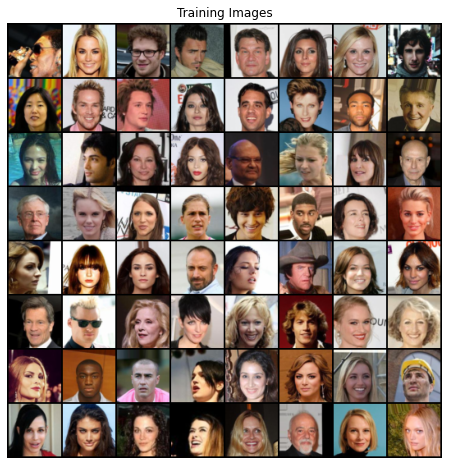

In [7]:

# dataset sample visualization

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:

# weight initialization

def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:

# build the generator 

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [10]:

# parameter initialization for Generator.
netG = Generator(ngpu).to(device)

# Handle multi-gpu 
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weight_init)

# print Generator model
#print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [11]:

# build the Discriminator.

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias= False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1,bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:

netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and ngpu > 1:
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weight_init)

#print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [13]:

# define loss function and optimizer

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.0
fake_label = 0.0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:

# Training loop

#progress details
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop ...")

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):
        # update netD for real data
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float,
        device = device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        #update netD for fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()

        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # update netG 
        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop ...
[0/5][0/1583]	Loss_D: 1.8248	Loss_G: 6.2165	D(x): 0.7556	D(G(z)): 0.7191 / 0.0039
[0/5][50/1583]	Loss_D: 0.3671	Loss_G: 26.8805	D(x): 0.8496	D(G(z)): 0.0000 / 0.0000
[0/5][100/1583]	Loss_D: 0.2160	Loss_G: 5.7812	D(x): 0.9443	D(G(z)): 0.0940 / 0.0066
[0/5][150/1583]	Loss_D: 0.3512	Loss_G: 5.1857	D(x): 0.7954	D(G(z)): 0.0319 / 0.0181
[0/5][200/1583]	Loss_D: 0.8621	Loss_G: 5.7589	D(x): 0.5608	D(G(z)): 0.0068 / 0.0114
[0/5][250/1583]	Loss_D: 1.5070	Loss_G: 2.9052	D(x): 0.4181	D(G(z)): 0.0081 / 0.1163
[0/5][300/1583]	Loss_D: 0.3530	Loss_G: 3.9198	D(x): 0.8520	D(G(z)): 0.1444 / 0.0357
[0/5][350/1583]	Loss_D: 0.6676	Loss_G: 3.7043	D(x): 0.7867	D(G(z)): 0.2618 / 0.0613
[0/5][400/1583]	Loss_D: 1.1559	Loss_G: 10.4468	D(x): 0.9584	D(G(z)): 0.5730 / 0.0003
[0/5][450/1583]	Loss_D: 1.4405	Loss_G: 2.4028	D(x): 0.3966	D(G(z)): 0.0519 / 0.1403
[0/5][500/1583]	Loss_D: 0.8351	Loss_G: 3.8050	D(x): 0.7248	D(G(z)): 0.2543 / 0.0508
[0/5][550/1583]	Loss_D: 0.4465	Loss_G: 6.7781	D(x)

[3/5][50/1583]	Loss_D: 0.5062	Loss_G: 3.1473	D(x): 0.8913	D(G(z)): 0.2978 / 0.0562
[3/5][100/1583]	Loss_D: 0.4971	Loss_G: 2.8577	D(x): 0.8176	D(G(z)): 0.2254 / 0.0750
[3/5][150/1583]	Loss_D: 0.4577	Loss_G: 2.4223	D(x): 0.8368	D(G(z)): 0.2163 / 0.1136
[3/5][200/1583]	Loss_D: 0.6852	Loss_G: 1.2906	D(x): 0.5999	D(G(z)): 0.0779 / 0.3152
[3/5][250/1583]	Loss_D: 0.9244	Loss_G: 4.1252	D(x): 0.9159	D(G(z)): 0.5166 / 0.0238
[3/5][300/1583]	Loss_D: 0.6116	Loss_G: 1.8907	D(x): 0.6669	D(G(z)): 0.1464 / 0.1980
[3/5][350/1583]	Loss_D: 0.7946	Loss_G: 1.5565	D(x): 0.5453	D(G(z)): 0.0696 / 0.2531
[3/5][400/1583]	Loss_D: 0.5835	Loss_G: 2.0522	D(x): 0.6336	D(G(z)): 0.0634 / 0.1652
[3/5][450/1583]	Loss_D: 1.0667	Loss_G: 4.1029	D(x): 0.8883	D(G(z)): 0.5667 / 0.0250
[3/5][500/1583]	Loss_D: 0.6343	Loss_G: 1.9365	D(x): 0.6886	D(G(z)): 0.1782 / 0.1774
[3/5][550/1583]	Loss_D: 0.7826	Loss_G: 1.2535	D(x): 0.6032	D(G(z)): 0.1666 / 0.3464
[3/5][600/1583]	Loss_D: 0.6439	Loss_G: 3.2832	D(x): 0.8801	D(G(z)): 0.3688 / 

In [21]:
torch.save(netD, './dcgan_dasc.pt')

In [22]:
torch.save(netG, './dcgan_gen.pt')

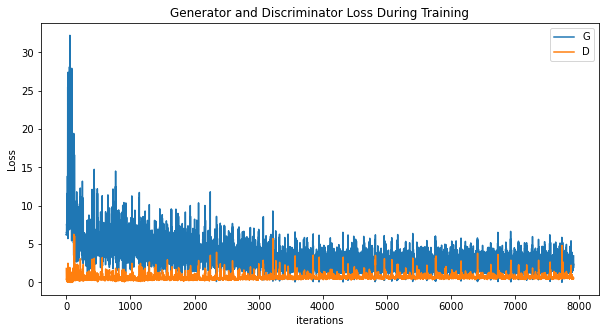

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())